In [3]:
import pickle
from pathlib import Path
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize, TwoSlopeNorm
from lameg.util import get_files, make_directory, check_many
from scipy.spatial.distance import euclidean
from scipy.stats import spearmanr, mode
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import itertools as it

In [4]:
def annotate_mx(im, txt_mx, **textkw):
    kw = dict(
        horizontalalignment="center",
        verticalalignment="center"
    )
    kw.update(textkw)
    for r, c in it.product(range(txt_mx.shape[0]), range(txt_mx.shape[1])):
        im.axes.text(r, c, txt_mx[r, c], **kw)

def colorbar(mappable, label):
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax, label=label)
    plt.sca(last_axes)
    return cbar


def plot_mx(mx, LAB, title="", ax=False, labels=False, cbar=False, cmap="Spectral_r", norm=False, cbar_label=r"$\Delta$ FE"):
    if not ax:
        f, ax = plt.subplots(1, 1)
    else:
        ax = ax
    if not norm:
        iw = ax.imshow(mx.T, cmap=cmap)
    else:
        iw = ax.imshow(mx.T, cmap=cmap, norm=norm)
    if labels:
        ax.set_ylabel("Evaluation Surface")
        ax.set_xlabel("Simulation Surface")
        ax.set_xticks(np.arange(11).astype(int))
        ax.set_xticklabels(LAB)
        ax.set_yticks(np.arange(11).astype(int))
        ax.set_yticklabels(LAB)
        plt.suptitle(title)
        plt.tight_layout()
    if cbar:
        colorbar(iw, cbar_label)
    return iw

def find_peaks(mx, marker="*", return_annot=True):
    annot = np.zeros(mx.shape).astype(np.object_)
    peaks = []
    for l in range(mx.shape[0]):
        peak = np.argmax(mx[l, :]) # here is the problem (you find peak in evaluated!)
        annot[peak, l] = 1.0
#         peak = np.argmax(mx[:, l])
#         annot[l, peak] = 1.0
        peaks.append(peak)
    peaks = np.array(peaks)
    annot_bin = np.copy(annot).astype(float)
    annot[annot==0.0] = None
    annot[annot==1.0] = marker
    if return_annot:
        return peaks, annot, annot_bin
    else:
        return peaks
    

def compare_values_with_threshold(a, b, c, threshold=5):
    def compare(x, y, threshold):
        # Consider values equal if the difference is smaller than or equal to threshold
        if abs(x - y) <= threshold:
            return 0
        elif x < y:
            return -1
        else:
            return 1

    # Compare all pairs with the threshold
    result_ab = compare(a, b, threshold)
    result_ac = compare(a, c, threshold)
    result_bc = compare(b, c, threshold)

    return result_ab, result_ac, result_bc


In [7]:
order_ = [list(i) for i in list(it.product(list(np.arange(11)), [5]))]
order_fix = []
for i in order_:
    if np.unique(i).shape[0] == 1:
        order_fix.append([i[0]])
    else:
        order_fix.append(i)

n_layers = 11
layers = np.arange(n_layers).astype(int)
LAB = list(layers)
LAB[0] = "P"
LAB[-1] = "W"

In [8]:
folder_path = Path("/scratch/coreg_analysis/mid_sd_iteration_2_source_coreg")
all_files = get_files(folder_path, "*.pickle", strings=["mid_sd"])

In [9]:
df_files = {
    "filename": [],
    "coreg_error": [],
    "base_vertex": [],
    "layers_used": [],
    "layerF":[],
    "layerF_abs":[]
}

for file_path in all_files:
    with open(file_path, "rb") as file:
        data = pickle.load(file)
    
    df_files["filename"].append(file_path)
    df_files["base_vertex"].append(data["base_vertex"])
    df_files["layers_used"].append(order_fix.index(data["layers_used"]))
    df_files["coreg_error"].append(data["coreg_error"])
    
    lFdata = None
    if len(data["layerF"].shape) == 2:
        lFdata = data["layerF"][0]
    else:
        lFdata = data["layerF"]
    
    df_files["layerF"].append(lFdata - np.min(lFdata))
    df_files["layerF_abs"].append(lFdata)

full_df = pd.DataFrame.from_dict(df_files)

In [10]:
coregs = full_df.coreg_error.unique()
base_vertices = full_df.base_vertex.unique()

full_df.head()

,filename,coreg_error,base_vertex,layers_used,layerF,layerF_abs
0,/scratch/coreg_analysis/mid_sd_iteration_2_sou...,0.0,161,0,"[1569.9648735386845, 1638.2270884205218, 1675....","[-6029.071550997142, -5960.809336115305, -5923..."
1,/scratch/coreg_analysis/mid_sd_iteration_2_sou...,0.0,26557,10,"[0.0, 199.55085524997594, 344.20381738984906, ...","[-5886.860114040288, -5687.309258790312, -5542..."
2,/scratch/coreg_analysis/mid_sd_iteration_2_sou...,0.0,26967,0,"[290.454004476529, 311.67651580417714, 321.278...","[-5977.631844646712, -5956.409333319064, -5946..."
3,/scratch/coreg_analysis/mid_sd_iteration_2_sou...,0.0,26967,1,"[234.49243068501164, 261.9258035420962, 277.34...","[-5982.495214043466, -5955.061841186382, -5939..."
4,/scratch/coreg_analysis/mid_sd_iteration_2_sou...,0.0,26967,2,"[183.63426025963872, 216.72877627109392, 237.4...","[-5992.985910391191, -5959.891394379736, -5939..."


In [76]:
full_df.loc[
    (full_df.base_vertex == 26967) &
    (full_df.coreg_error == 0.5) &
    (full_df.layers_used == 2)
]

,filename,coreg_error,base_vertex,layers_used,layerF,layerF_abs
1226,/scratch/coreg_analysis/mid_sd_iteration_2_sou...,0.5,26967,2,"[183.63426025963872, 216.72877627109392, 237.4...","[-5992.985910391191, -5959.891394379736, -5939..."


In [11]:
source_dist = np.zeros((n_layers, n_layers)).astype(np.object_)
source_dist[source_dist == 0] = None
for i in order_:
    source_dist[i[0], i[0]] = r"$\bullet$"
    source_dist[i[0], i[1]] = r"$\bullet$"

In [12]:
labs = ["pial", "middle", "white"]

comparisons = [[0, 1], [0, 2], [1, 2]]
comp_labs = [[labs[j] for j in i] for i in comparisons]
comp_col = {
    0: "#fe4a49",
    1: "#fed766",
    2: "#009fb7",
}

labs = ["pial", "middle", "white"]
lab_col = {
    "pial": "#fe4a49",
    "middle": "#fed766",
    "white": "#009fb7",
}

In [16]:
matrices_all = {i: [] for i in coregs}
peaks_all = {i: [] for i in coregs}
annots_bin = {i: [] for i in coregs}
pwm_dfe = {i: [] for i in coregs}
bin_comp = {i: [] for i in coregs}

for base_vertex in base_vertices:
    for coreg_ix, coreg in enumerate(coregs):
        mx = np.vstack(full_df.loc[
            (full_df.base_vertex == base_vertex) &
            (full_df.coreg_error == coreg)
        ].layerF.to_list())
        
        mx_abs = np.vstack(full_df.loc[
            (full_df.base_vertex == base_vertex) &
            (full_df.coreg_error == coreg)
        ].layerF_abs.to_list())

        peaks, annot, annot_bin = find_peaks(mx, marker=r"$\wedge$")
        matrices_all[coreg].append(mx)
        peaks_all[coreg].append(peaks)
        annots_bin[coreg].append(annots_bin)
        
        pmw_abs = mx_abs[:, [0, 5, -1]].T
        pmw_rel = pmw_abs - np.min(pmw_abs, axis=0)
        
        pwm_dfe[coreg].append(pmw_rel)
        pwm_bin = np.array([compare_values_with_threshold(*pmw_rel[:,i], threshold=50) for i in np.arange(n_layers)])                
        bin_comp[coreg].append(pwm_bin)


In [49]:
np.vstack(full_df.loc[
    (full_df.base_vertex == 26531) &
    (full_df.coreg_error == 1)
].layerF_abs.to_list())

array([[-4432.04885328, -4421.51736746, -4415.78958984, -4414.94056605,
        -4422.27095136, -4432.70034584, -4475.78589134, -4509.1006655 ,
        -4551.63844719, -4604.73368354, -4678.02543759],
       [-4434.34211582, -4421.26950106, -4412.86271082, -4409.72220012,
        -4413.40839351, -4421.46126287, -4459.88118352, -4490.68891299,
        -4530.7934358 , -4581.548753  , -4652.82919046],
       [-4454.39470781, -4438.79025735, -4427.70621295, -4422.31460964,
        -4422.3410025 , -4428.07470645, -4461.95662146, -4490.34191062,
        -4528.11133499, -4576.63932759, -4646.07554099],
       [-4457.68554181, -4439.7939093 , -4426.32383586, -4418.63811643,
        -4415.50653175, -4418.72691673, -4447.38780381, -4472.92271694,
        -4507.80370942, -4553.41663767, -4619.82708104],
       [-4466.79313884, -4445.3158883 , -4428.03332266, -4417.23696176,
        -4408.5011018 , -4408.49181744, -4430.06413404, -4452.20495962,
        -4483.85081784, -4526.42251973, -4590.436059

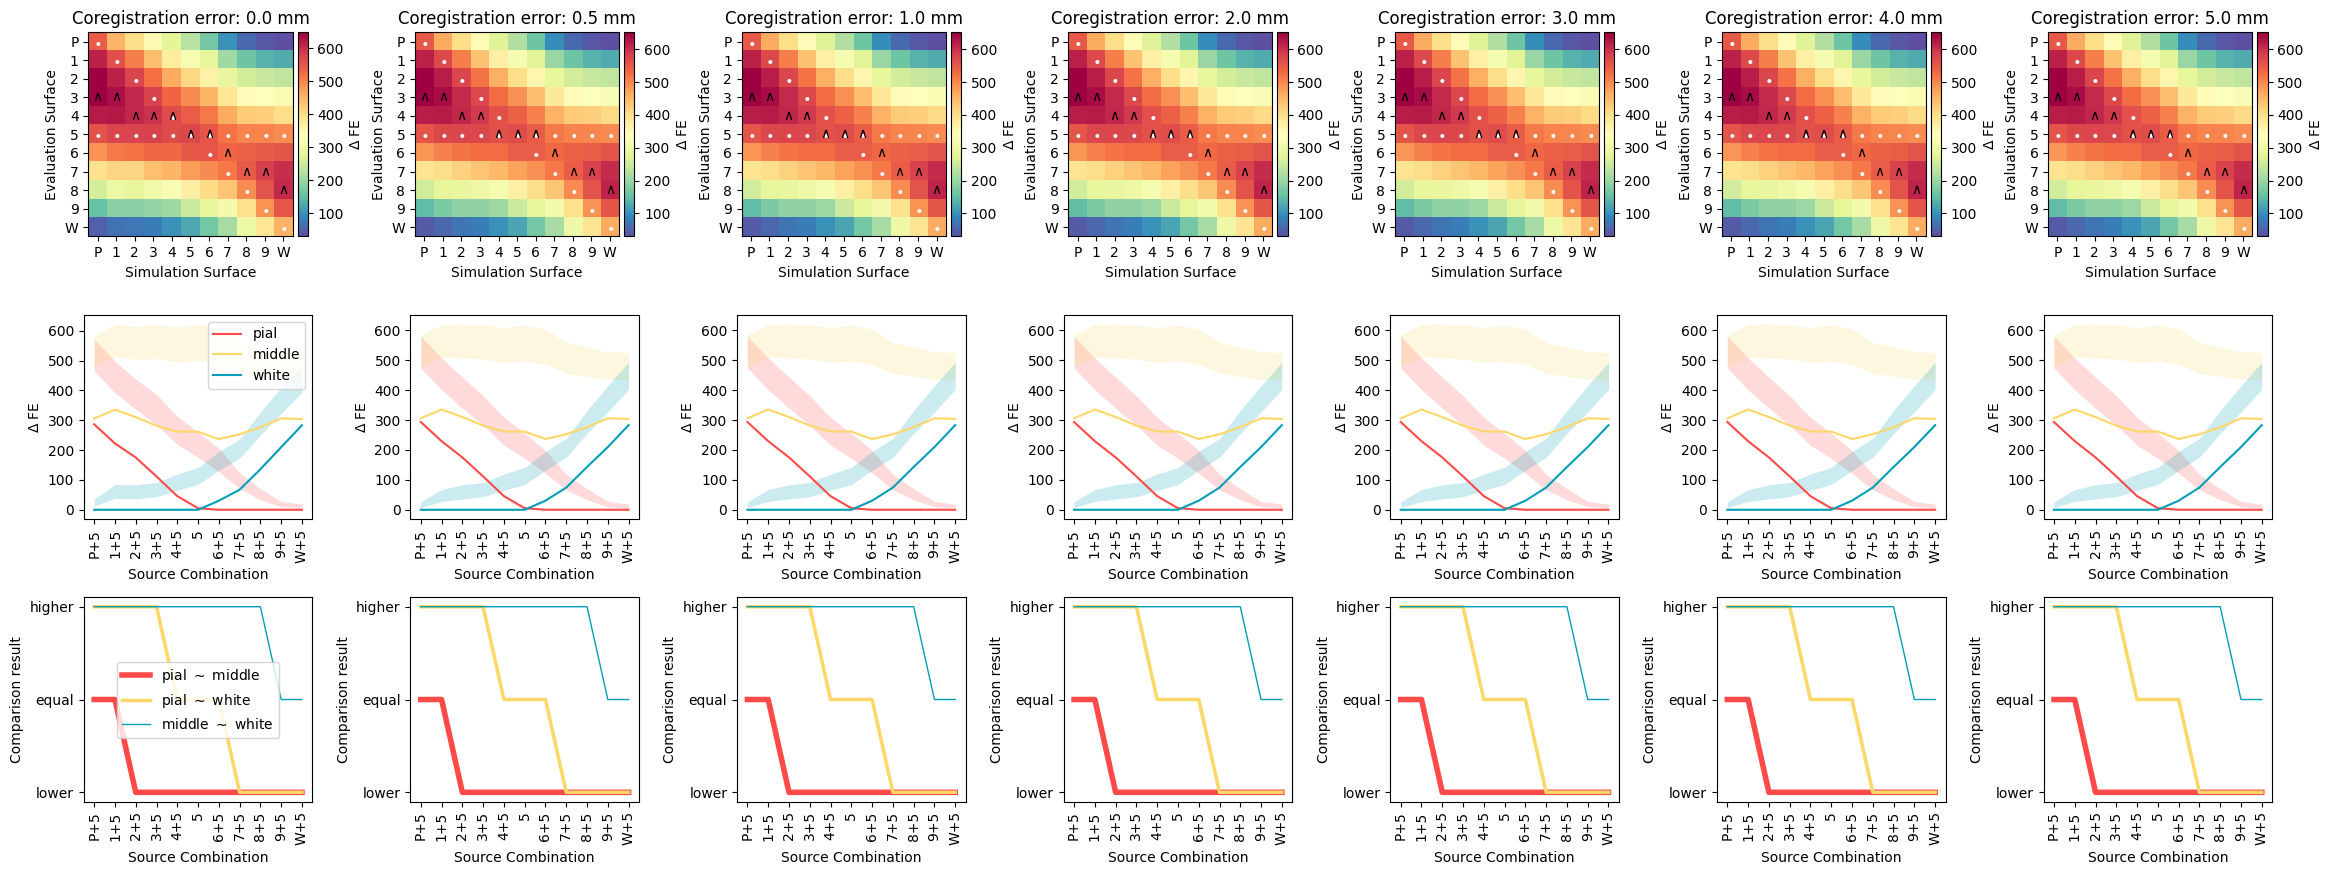

In [15]:
f, ax = plt.subplots(3, coregs.shape[0], figsize=(23.4, 9), facecolor="white")
for coreg_ix, coreg in enumerate(coregs):
    ax[0,coreg_ix].set_title(f"Coregistration error: {coreg} mm")
    
    mx = np.mean(matrices_all[coreg], axis=0)
    peaks, annot, annot_bin = find_peaks(mx, marker=r"$\wedge$")
    # to counteract the T use np.rot90(np.fliplr(mx))
    iw = plot_mx(mx, LAB, ax=ax[0,coreg_ix], labels=True, cbar=True, cbar_label=r"$\Delta$ FE")
    annotate_mx(iw, source_dist, c="white")
#     annotate_mx(iw, annot)
    annotate_mx(iw, np.rot90(np.fliplr(annot)))
    
    pmw = np.stack(pwm_dfe[coreg])
    
    for ordr, ix in enumerate([0, 5, -1]):
        ax[1,coreg_ix].plot(np.arange(n_layers), np.median(pmw[:, ordr, :], axis=0), label=labs[ordr], c=lab_col[labs[ordr]])
        sem = np.std(pmw[:, ordr, :], axis=0) / np.sqrt(100)
        sem_low = np.mean(pmw[:, ordr, :], axis=0) - sem
        sem_hi = np.mean(pmw[:, ordr, :], axis=0) + sem
        ax[1,coreg_ix].fill_between(np.arange(n_layers), sem_low, sem_hi, lw=0, color=lab_col[labs[ordr]], alpha=0.2)
        
    ax[1,coreg_ix].set_xticks(np.arange(n_layers))
    ax[1,coreg_ix].set_xticklabels(["+".join([str(LAB[x]) for x in i]) for i in order_fix])
    ax[1,coreg_ix].tick_params(axis='x', labelrotation=90)
    ax[1,coreg_ix].set_ylabel(r"$\Delta$ FE")
    ax[1,coreg_ix].set_xlabel("Source Combination")
    
    for comp_ix, comp_lab in enumerate(comp_labs):
        comp = np.stack(bin_comp[coreg])[:, :, comp_ix]
        ax[2, coreg_ix].plot(
            np.arange(n_layers),
#             mode(comp, axis=0).mode[0],
            np.median(comp, axis=0),
            label=fr"{comp_lab[0]} $\sim$ {comp_lab[1]}",
            c=comp_col[comp_ix],
            lw=4-comp_ix*1.5
        )
        
    ax[2,coreg_ix].set_xticks(np.arange(n_layers))
    ax[2,coreg_ix].set_xticklabels(["+".join([str(LAB[x]) for x in i]) for i in order_fix])
    ax[2,coreg_ix].tick_params(axis='x', labelrotation=90)
    ax[2,coreg_ix].set_ylabel(r"Comparison result")
    ax[2,coreg_ix].set_xlabel("Source Combination")
    ax[2,coreg_ix].set_yticks([-1, 0, 1])
    ax[2,coreg_ix].set_yticklabels(["lower", "equal", "higher"])

ax[1,0].legend()
ax[2,0].legend()
plt.tight_layout()
plt.savefig("/scratch/coreg_analysis/img_outputs/coreg_2_source_mid_sd.svg")

In [15]:
pwm_dfe[5]

[array([[1201.27361046, 1114.53551876, 1664.86242616, 1436.67566227,
         1200.75065626,  960.99779886,  483.8401255 ,    0.        ,
            0.        ,    0.        ,    0.        ],
        [1215.11056296, 1205.36036922, 1834.33800022, 1688.66476024,
         1537.75470533, 1384.19618406, 1075.6425695 ,  809.0663116 ,
          936.44073233, 1064.77530773, 1190.66493318],
        [   0.        ,    0.        ,    0.        ,    0.        ,
            0.        ,    0.        ,    0.        ,  134.62207988,
          496.44644094,  861.85782302, 1221.76808409]]),
 array([[861.33559043, 713.30133669, 589.41670108, 446.23070024,
         291.08591631, 159.03581314,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ],
        [860.1022865 , 778.78434563, 710.85853515, 632.14952201,
         546.7201091 , 474.79964278, 388.8866127 , 455.79346905,
         514.13526664, 562.27221294, 699.53244282],
        [  0.        ,   0.        ,   0.        ,   0.

In [19]:
pwm_dfe[0][0][0][0]

1201.273610459537

In [20]:
pwm_dfe[5][0][0][0]

1201.273610459537